# Predicting Release Year of Songs Based on Acoustic Features

RAW DATA: http://archive.ics.uci.edu/ml/datasets/YearPredictionMSD
<br>
KAGGLE VERSION: https://www.kaggle.com/uciml/msd-audio-features/version/1

<br>
This is a dataset of timbre (https://en.wikipedia.org/wiki/Timbre) information and release year for ~500,000 songs.
<br>
Songs are mostly western, commercial tracks ranging from 1922 to 2011, with a peak in the year 2000s.
<br>
Consists of 90 attributes, 12 of which are timbre averages, and 78 of which are timbre covariances
<br>
The timbre covariance is the covariance over the time series samples of the 12 features (Timbre 1 through 12). 
<br>
<br>
MORE FEATURE INFORMATION:
Data extracted from the 'timbre' feature provided by The Echo Nest API. 
We take the average and covariance over all 'segments', each segment 
being described by a 12-dimensional timbre vector.

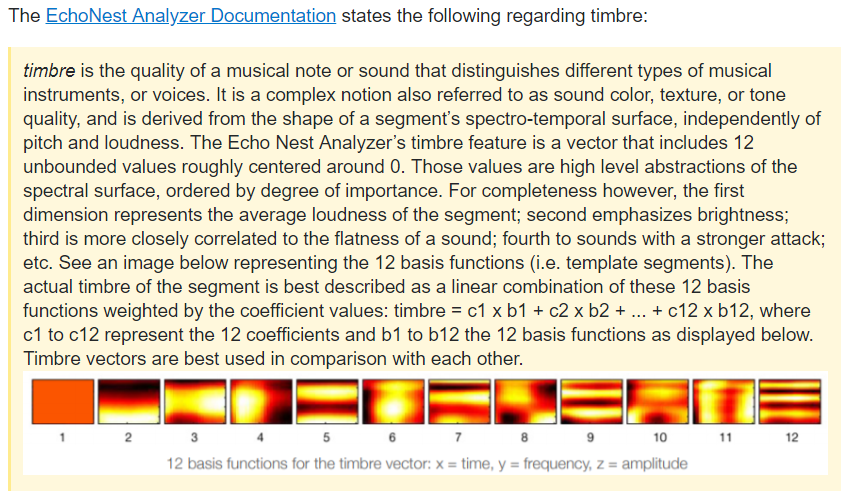

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)

import matplotlib.pyplot as plt
import seaborn as sns

# Raw Data

In [2]:
df = pd.read_csv('C:/dev/Datasets/song_timbre/year_prediction.csv', sep=',')

In [3]:
df.rename({'label': 'Year released'}, axis='columns', inplace=True)
df.sample(8)

,Year released,TimbreAvg1,TimbreAvg2,TimbreAvg3,TimbreAvg4,TimbreAvg5,TimbreAvg6,TimbreAvg7,TimbreAvg8,TimbreAvg9,TimbreAvg10,TimbreAvg11,TimbreAvg12,TimbreCovariance1,TimbreCovariance2,TimbreCovariance3,TimbreCovariance4,TimbreCovariance5,TimbreCovariance6,TimbreCovariance7,TimbreCovariance8,TimbreCovariance9,TimbreCovariance10,TimbreCovariance11,TimbreCovariance12,TimbreCovariance13,TimbreCovariance14,TimbreCovariance15,TimbreCovariance16,TimbreCovariance17,TimbreCovariance18,TimbreCovariance19,TimbreCovariance20,TimbreCovariance21,TimbreCovariance22,TimbreCovariance23,TimbreCovariance24,TimbreCovariance25,TimbreCovariance26,TimbreCovariance27,TimbreCovariance28,TimbreCovariance29,TimbreCovariance30,TimbreCovariance31,TimbreCovariance32,TimbreCovariance33,TimbreCovariance34,TimbreCovariance35,TimbreCovariance36,TimbreCovariance37,TimbreCovariance38,TimbreCovariance39,TimbreCovariance40,TimbreCovariance41,TimbreCovariance42,TimbreCovariance43,TimbreCovariance44,TimbreCovariance45,TimbreCovariance46,TimbreCovariance47,TimbreCovariance48,TimbreCovariance49,TimbreCovariance50,TimbreCovariance51,TimbreCovariance52,TimbreCovariance53,TimbreCovariance54,TimbreCovariance55,TimbreCovariance56,TimbreCovariance57,TimbreCovariance58,TimbreCovariance59,TimbreCovariance60,TimbreCovariance61,TimbreCovariance62,TimbreCovariance63,TimbreCovariance64,TimbreCovariance65,TimbreCovariance66,TimbreCovariance67,TimbreCovariance68,TimbreCovariance69,TimbreCovariance70,TimbreCovariance71,TimbreCovariance72,TimbreCovariance73,TimbreCovariance74,TimbreCovariance75,TimbreCovariance76,TimbreCovariance77,TimbreCovariance78
212923,2003,24.04001,-201.04381,-103.12594,-60.13983,-16.04279,-45.19720,25.42368,17.12694,-37.96585,-6.42739,-4.20353,-17.95081,11.69248,1726.59890,1677.67740,581.16458,807.04912,182.93477,428.35764,113.07725,590.27618,89.51664,39.01706,507.95317,-112.75698,-49.95947,770.91634,-216.62532,-202.40914,-39.35369,62.04472,-25.44256,174.35664,-18.92945,61.79863,73.48368,-7.36873,-342.46771,116.17445,51.34423,-3.10827,27.66570,-19.23097,-12.65985,28.15141,36.60647,-19.74154,289.49390,147.75198,3.41235,-188.70403,20.56415,-4.49915,201.69804,-40.86479,28.28723,330.49109,160.48977,438.73560,-24.86818,0.45754,-2.51030,16.51265,-155.76606,88.66614,-271.31570,150.39272,-21.40699,115.40453,18.88538,-56.19667,-551.78939,-92.17697,8.03068,-139.25237,6.71489,176.28445,-133.51831,-26.03675,291.21161,-41.19790,118.74525,-26.84883,-204.27503,-17.13852,-80.26434,-365.32782,3.98588,-87.72022,-15.21026
505030,1999,32.60304,-16.27854,-70.61220,-9.15208,-31.57089,1.28193,-20.93040,3.71823,-3.43763,7.72327,-2.87398,6.45357,24.67971,4448.83922,1600.01130,2628.84571,919.97498,1401.96139,710.98049,1721.21678,586.67012,799.71707,640.20169,353.20353,47.74069,-861.85023,-401.92291,-7.14268,39.07825,213.04418,-90.58694,191.33185,-176.61534,14.00235,-24.71382,48.37301,-806.79822,119.76343,-391.01046,170.57785,-137.18279,-72.30970,-156.18976,72.98998,-46.18405,-39.73000,195.05125,198.20483,-228.82740,80.86679,-23.40619,14.37857,192.69318,-11.97934,-14.61737,42.48853,313.28457,-70.62801,127.71398,-31.64824,-37.14610,-33.87859,29.19833,-287.39068,253.99626,-22.11008,-6.54979,-37.83708,6.79817,-4.99487,-453.62040,-202.60945,220.29286,31.74386,-102.01702,-25.64624,218.10388,109.07052,-295.34850,26.33736,-1.84196,-573.22313,97.00262,-106.42205,-9.67823,89.89855,-74.94065,-9.87918,184.09460,13.65239
302449,2007,49.01401,46.91711,-9.21684,-12.36921,-36.53417,-28.13036,3.51151,-1.42338,19.38937,10.79561,-1.83103,6.47311,20.16148,1289.40460,879.30641,403.55216,301.49419,582.40696,291.30295,170.99301,179.89244,118.49212,134.00156,137.15857,129.29673,566.86314,-94.17928,16.42625,-76.85413,45.56438,8.15381,24.38811,3.51436,11.30667,0.12429,108.53584,-78.19266,223.39081,-93.40184,0.40013,-24.93215,29.44912,-4.27142,-14.11987,-11.45415,-4.13666,163.26752,-190.90385,-10.69864,77.51726,41.45599,6.40572,1.76691,-11.95451,34.33256,-333.14252,-13.46813,-84.89939,-4.93764,-138.92726,-28.4

In [4]:
df.describe()

,Year released,TimbreAvg1,TimbreAvg2,TimbreAvg3,TimbreAvg4,TimbreAvg5,TimbreAvg6,TimbreAvg7,TimbreAvg8,TimbreAvg9,TimbreAvg10,TimbreAvg11,TimbreAvg12,TimbreCovariance1,TimbreCovariance2,TimbreCovariance3,TimbreCovariance4,TimbreCovariance5,TimbreCovariance6,TimbreCovariance7,TimbreCovariance8,TimbreCovariance9,TimbreCovariance10,TimbreCovariance11,TimbreCovariance12,TimbreCovariance13,TimbreCovariance14,TimbreCovariance15,TimbreCovariance16,TimbreCovariance17,TimbreCovariance18,TimbreCovariance19,TimbreCovariance20,TimbreCovariance21,TimbreCovariance22,TimbreCovariance23,TimbreCovariance24,TimbreCovariance25,TimbreCovariance26,TimbreCovariance27,TimbreCovariance28,TimbreCovariance29,TimbreCovariance30,TimbreCovariance31,TimbreCovariance32,TimbreCovariance33,TimbreCovariance34,TimbreCovariance35,TimbreCovariance36,TimbreCovariance37,TimbreCovariance38,TimbreCovariance39,TimbreCovariance40,TimbreCovariance41,TimbreCovariance42,TimbreCovariance43,TimbreCovariance44,TimbreCovariance45,TimbreCovariance46,TimbreCovariance47,TimbreCovariance48,TimbreCovariance49,TimbreCovariance50,TimbreCovariance51,TimbreCovariance52,TimbreCovariance53,TimbreCovariance54,TimbreCovariance55,TimbreCovariance56,TimbreCovariance57,TimbreCovariance58,TimbreCovariance59,TimbreCovariance60,TimbreCovariance61,TimbreCovariance62,TimbreCovariance63,TimbreCovariance64,TimbreCovariance65,TimbreCovariance66,TimbreCovariance67,TimbreCovariance68,TimbreCovariance69,TimbreCovariance70,TimbreCovariance71,TimbreCovariance72,TimbreCovariance73,TimbreCovariance74,TimbreCovariance75,TimbreCovariance76,TimbreCovariance77,TimbreCovariance78
count,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000
mean,1998.397082,43.387126,1.289554,8.658347,1.164124,-6.553601,-9.521975,-2.391089,-1.793236,3.727876,1.882385,-0.146527,2.546063,33.714006,2439.359375,1967.734202,1514.859902,910.981344,879.146721,603.737434,517.579339,393.962215,325.733170,288.885085,291.973238,43.031969,43.314873,-46.449006,-27.672783,14.958491,44.514859,5.131786,24.034309,9.498816,-4.178856,0.499475,72.652267,-51.441256,117.921056,-189.880885,23.096082,-1.283005,18.147973,-51.959022,3.232686,-1.488321,6.334084,78.702427,142.696868,-86.516476,25.240753,6.378511,28.294082,12.772241,1.700474,-10.205155,64.101262,104.822085,-0.026481,38.678040,-27.989985,3.301739,0.307127,-0.478828,-138.223224,-0.696065,0.242582,3.151751,27.642745,31.822244,-0.835950,-8.931564,4.849253,-27.347646,-11.938792,-21.572137,-5.576196,-23.304324,31.113053,-104.974794,26.962393,15.755406,-73.461500,41.542422,37.934119,0.315751,17.669213,-26.315336,4.458641,20.035136,1.329105
std,10.931046,6.067558,51.580351,35.268585,16.322790,22.860785,12.857751,14.571873,7.963827,10.582861,6.530232,4.370848,8.320190,22.259632,1749.367690,1261.484792,10

### Train / Test Split 

This split, recommended by UC Irvine Machine Learning Repository, avoids the 'producer effect' by making sure no song from a given artist ends up in both the train and test set.

In [5]:
train = df[0:463715]
print('Length of training data: ' + str(len(train)))
test = df[463715:]
print('Length of test data: ' + str(len(test)))

Length of training data: 463715
Length of test data: 51630


# Data Distributions

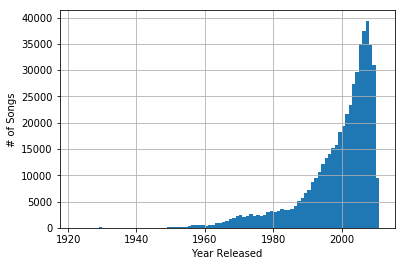

In [6]:
target = df.loc[:,'Year released']

plt.ylabel('# of Songs')
plt.xlabel('Year Released')
bins = 2011 - 1922 #create a bar for each year
target.hist(bins=bins)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001AF0000F860>,
      dtype=object)

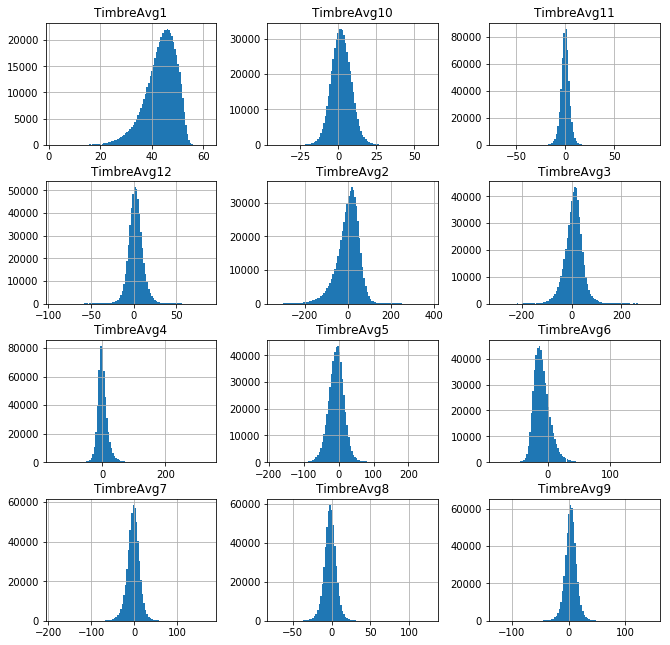

In [7]:
features = df.iloc[:,1:]
avg_timbre = features.iloc[:,0:12]
avg_timbre.hist(figsize=(11,11), bins=100)

In [8]:
covar_mat = avg_timbre.cov() 

covars = []
for index, row in covar_mat.iterrows():
    for col in list(covar_mat.columns.values):
        covars.append(row[col])
        
seen = []
for covar in covars:
    if covar in seen:
        pass
    else:
        seen.append(covar)
        
print('There are ' + str(len(seen)) + ' unique timbre covariance features based on the matrix of timbre features recorded for each song')
print('12 of these covariances are actually univariate variances from the diagonal of the matrix')
print('There are 66 duplicate covariances in the matrix, and 66 unique covariances')
print('An individual covariance represents the covariance between 2 samples of timbre features for that song')

There are 78 unique timbre covariance features based on the matrix of timbre features recorded for each song
12 of these covariances are actually univariate variances from the diagonal of the matrix
There are 66 duplicate covariances in the matrix, and 66 unique covariances
An individual covariance represents the covariance between 2 samples of timbre features for that song


In [ ]:
timbre_covar = features.iloc[:,12:]
timbre_cov_cols = list(timbre_covar.columns.values)
for col in timbre_cov_cols: #iterate through col names and plot each separately so they are sorted in order
    timbre_covar[[col]].hist(figsize=(4,3), bins=100)

Based on the marked difference in the distribution of the first 12 covariance distributions (plotted above), relative to the other covariance features, it seems that these are the univariate variances of each timbre feature recorded. These values are all positive, and much larger than the covariances, since the variance is the square of standard deviation.

C:\Anaconda\lib\site-packages\pandas\core\frame.py:3778: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001AF07D76940>,
      dtype=object)

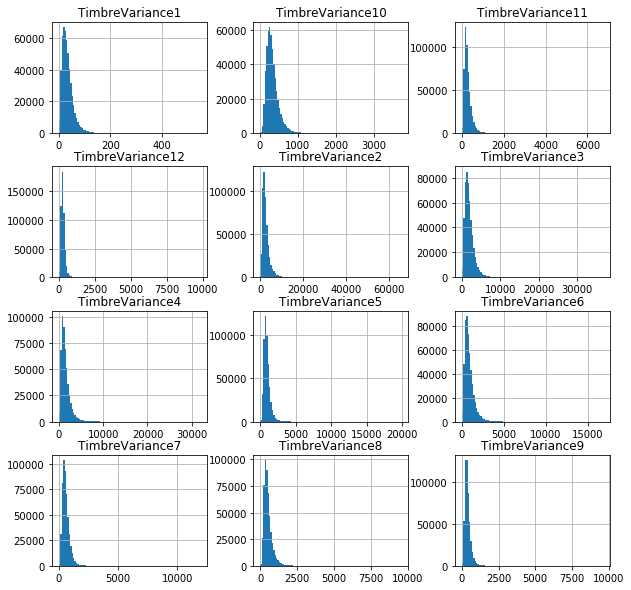

In [10]:
timbre_variances = timbre_covar.iloc[:,0:12]

#replace the column headers with 'Variance' instead of 'Covariance'
old_colnames = list(timbre_variances.columns.values)

new_colnames = []
for idx in range(1,13):
    new_colnames.append('TimbreVariance' + str(idx))
    

replace_dict = dict(list(zip(old_colnames, new_colnames)))
    
timbre_variances.rename(replace_dict,axis='columns', inplace=True)

timbre_variances.hist(figsize=(10,10),bins=100)

In [11]:
timbre_covar = timbre_covar.iloc[:,12:] #update the dataframe to exclude the variance columns
old_colnames = list(timbre_covar.columns.values)
new_colnames = []
for idx in range(1,67): #update the covariance column names from 13, 14, . . ., 78 to 1, 2, . . ., 66
    new_colnames.append('TimbreCovariance' + str(idx))

replace_dict = dict(list(zip(old_colnames, new_colnames)))
    
timbre_covar.rename(replace_dict,axis='columns', inplace=True)

In [12]:
#this feature matrix is split into Timbre Averages, Timbre Variances, and Timbre Covariances, all named correctly
features = pd.concat([avg_timbre, timbre_variances, timbre_covar], axis=1)
display(features.head())

,TimbreAvg1,TimbreAvg2,TimbreAvg3,TimbreAvg4,TimbreAvg5,TimbreAvg6,TimbreAvg7,TimbreAvg8,TimbreAvg9,TimbreAvg10,TimbreAvg11,TimbreAvg12,TimbreVariance1,TimbreVariance2,TimbreVariance3,TimbreVariance4,TimbreVariance5,TimbreVariance6,TimbreVariance7,TimbreVariance8,TimbreVariance9,TimbreVariance10,TimbreVariance11,TimbreVariance12,TimbreCovariance1,TimbreCovariance2,TimbreCovariance3,TimbreCovariance4,TimbreCovariance5,TimbreCovariance6,TimbreCovariance7,TimbreCovariance8,TimbreCovariance9,TimbreCovariance10,TimbreCovariance11,TimbreCovariance12,TimbreCovariance13,TimbreCovariance14,TimbreCovariance15,TimbreCovariance16,TimbreCovariance17,TimbreCovariance18,TimbreCovariance19,TimbreCovariance20,TimbreCovariance21,TimbreCovariance22,TimbreCovariance23,TimbreCovariance24,TimbreCovariance25,TimbreCovariance26,TimbreCovariance27,TimbreCovariance28,TimbreCovariance29,TimbreCovariance30,TimbreCovariance31,TimbreCovariance32,TimbreCovariance33,TimbreCovariance34,TimbreCovariance35,TimbreCovariance36,TimbreCovariance37,TimbreCovariance38,TimbreCovariance39,TimbreCovariance40,TimbreCovariance41,TimbreCovariance42,TimbreCovariance43,TimbreCovariance44,TimbreCovariance45,TimbreCovariance46,TimbreCovariance47,TimbreCovariance48,TimbreCovariance49,TimbreCovariance50,TimbreCovariance51,TimbreCovariance52,TimbreCovariance53,TimbreCovariance54,TimbreCovariance55,TimbreCovariance56,TimbreCovariance57,TimbreCovariance58,TimbreCovariance59,TimbreCovariance60,TimbreCovariance61,TimbreCovariance62,TimbreCovariance63,TimbreCovariance64,TimbreCovariance65,TimbreCovariance66
0,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,-2.46783,3.32136,-2.31521,10.20556,611.10913,951.08960,698.11428,408.98485,383.70912,326.51512,238.11327,251.42414,187.17351,100.42652,179.19498,-8.41558,-317.87038,95.86266,48.10259,-95.66303,-18.06215,1.96984,34.42438,11.72670,1.36790,7.79444,-0.36994,-133.67852,-83.26165,-37.29765,73.04667,-37.36684,-3.13853,-24.21531,-13.23066,15.93809,-18.60478,82.15479,240.57980,-10.29407,31.58431,-25.38187,-3.90772,13.29258,41.55060,-7.26272,-21.00863,105.50848,64.29856,26.08481,-44.59110,-8.30657,7.93706,-10.73660,-95.44766,-82.03307,-35.59194,4.69525,70.95626,28.09139,6.02015,-37.13767,-41.12450,-8.40816,7.19877,-8.60176,-5.90857,-12.32437,14.68734,-54.32125,40.14786,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,4.59210,2.21920,0.34006,44.38997,2056.93836,605.40696,457.41175,777.15347,415.64880,746.47775,366.45320,317.82946,273.07917,141.75921,317.35269,19.48271,-65.25496,162.75145,135.00765,-96.28436,-86.87955,17.38087,45.90742,32.49908,-32.85429,45.10830,26.84939,-302.57328,-41.71932,-138.85034,202.18689,-33.44277,195.04749,-16.93235,-1.09168,-25.38061,-12.19034,-125.94783,121.74212,136.67075,41.18157,28.55107,1.52298,70.99515,-43.63073,-42.55014,129.82848,79.95420,-87.14554,-45.75446,-65.82100,-43.90031,-19.45705,12.59163,-407.64130,42.91189,12.15850,-88.37882,42.25246,46.49209,-30.17747,45.98495,130.47892,13.88281,-4.00055,17.85965,-18.32138,-87.99109,14.37524,-22.70119,-58.81266,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,1.39518,2.73553,0.82804,7.46586,699.54544,1016.00954,594.06748,355.73663,507.39931,387.69910,287.15347,112.37152,161.68928,144.14353,199.29693,-4.24359,-297.00587,-148.36392,-7.94726,-18.71630,12.77542,-25.37725,9.71410,0.13843,26.79723,6.30760,28.70107,-74.89005,-289.19553,-166.26089,13.09302,5.89085,6.89034,-10.97160,1.67565,11.43523,-7.27994,133.08169,141.86758,-56.99356,98.15952,18.50939,16.97216,24.26629,-10.50788,-8.68412,54.75759,194.74034,7.95966,-18.22685,0.06463,-2.63069,26.02561,1.75729,-262.36917,-233.60089,-2.50502,-12.14279,81.37617,2.07554,-1.82381,183.65292,22.64797,-39.98887,43.37381,-31.56737,-4.88840,-36.53213

# Correlation Analysis

The Timbre Average features seem to have little linear correlation, save for weak correlations (~0.5 or -0.5) for a few features.
<br>
<br>
The Timbre Variance features are highly correlated with each other.
<br>
<br>
The Timbre Covariance features are largely uncorrelated with each other, although there seems to be more positive correlation than negative correlation.
<br>
<br>
An interesting correlation pattern exists between the Timbre Averages, and the Timbre Variances - Averages 1, 2, and 3 are negatively correlated with the Variance features. Averages 3, 4, and 5 are positively correlated with the Variance features. The remaining averages are uncorrelated with variance.
<br>
<br> 
Very little correlation exists between the target variable, Year Released, and any of the features.
<br>
Overall, there is a quite a bit of correlation amongst the features, and there are too many features to interpret, so a dimensionality reduction technique like PCA will be necessary to ensure feature independence and interpretability.

In [13]:
def corr_heatmap(corr_matrix,vmin,vmax): 
    """Takes a pandas correlation matrix as input and generates a heatmap"""
    # Generate a mask for the upper triangle of heat map
    mask = np.zeros_like(corr_matrix, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(10, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    display(sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=vmax, vmin=vmin, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}))

Timbre Avg Correlations: 


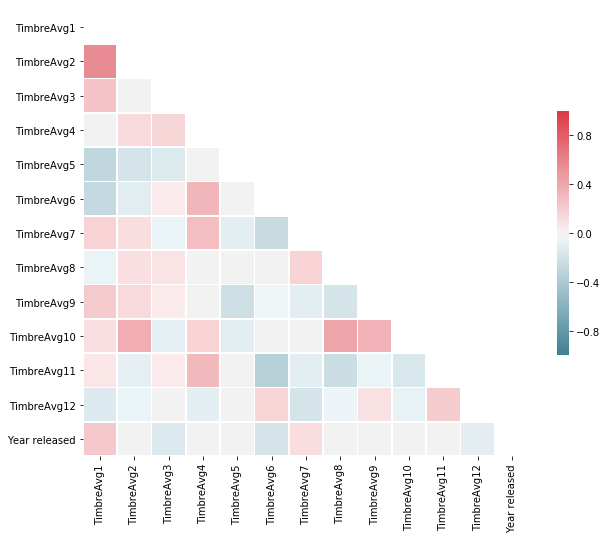

In [14]:
print('Timbre Avg Correlations: ')
avg_corr = pd.concat([avg_timbre,target], axis=1).corr()
corr_heatmap(avg_corr,-1,1)

Timbre Variance Correlations: 


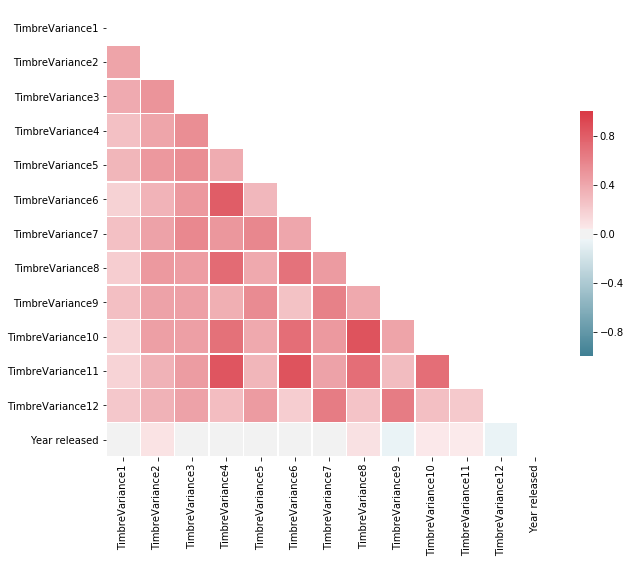

In [15]:
print('Timbre Variance Correlations: ')
var_corr = pd.concat([timbre_variances,target], axis=1).corr()
corr_heatmap(var_corr,-1,1)

Timbre Covariance Correlations: 


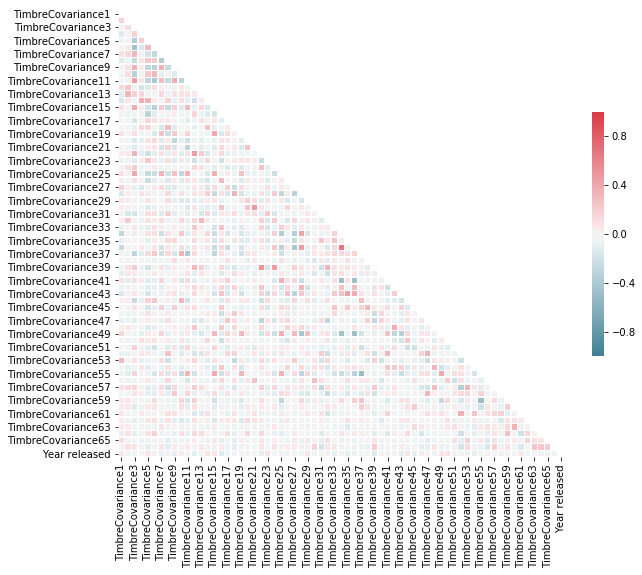

In [16]:
print('Timbre Covariance Correlations: ')
covar_corr = pd.concat([timbre_covar, target], axis=1).corr()
corr_heatmap(covar_corr,-1,1)

Timbre Average-Variance Correlations: 


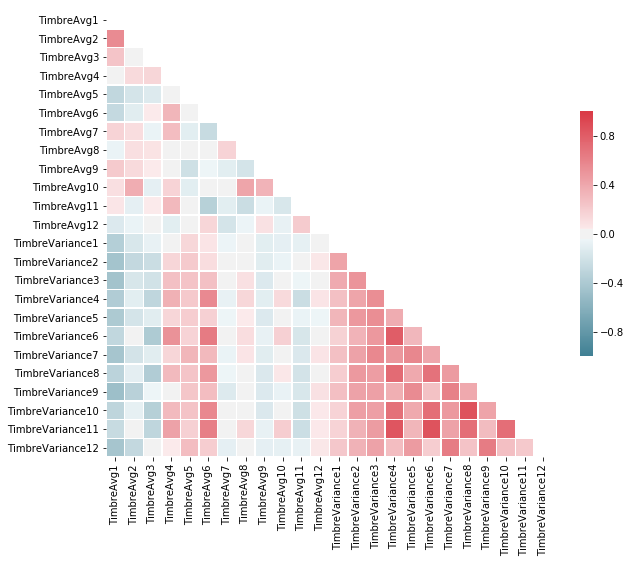

In [17]:
print('Timbre Average-Variance Correlations: ')
avg_var_corr = pd.concat([avg_timbre, timbre_variances], axis=1).corr()
corr_heatmap(avg_var_corr,-1,1)